In [617]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

from datetime import datetime, timedelta

from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind
from statsmodels.stats.proportion import proportion_confint

# Введение

In [618]:
delivery_data =pd.read_csv("restaurant-orders.csv")

In [619]:
delivery_data.columns

Index(['Date', 'Time customer placed order', 'Time order placed at restaurant',
       'Time driver arrived at restaurant', 'Delivery time', 'Driver ID',
       'Driver Name', 'Restaurant ID', 'Customer ID', 'Delivery Area', 'ASAP',
       'Sub Total', 'Delivery fee', 'Service fee', 'Discount', 'Tip',
       'Refunded amount'],
      dtype='object')

In [620]:
delivery_data.isna().sum()

Date                                     0
Time customer placed order               0
Time order placed at restaurant        160
Time driver arrived at restaurant    18124
Delivery time                            0
Driver ID                                0
Driver Name                              0
Restaurant ID                            0
Customer ID                              0
Delivery Area                            0
ASAP                                     0
Sub Total                                0
Delivery fee                             0
Service fee                              0
Discount                                 0
Tip                                      0
Refunded amount                          0
dtype: int64

In [621]:
delivery_data.head()

,Date,Time customer placed order,Time order placed at restaurant,Time driver arrived at restaurant,Delivery time,Driver ID,Driver Name,Restaurant ID,Customer ID,Delivery Area,ASAP,Sub Total,Delivery fee,Service fee,Discount,Tip,Refunded amount
0,2020-01-01,02:52:12,03:00:25,03:08:09,03:35:20,9329,Christy,7263,1143515,Fremont,Yes,$21.39,$0.43,$3.83,$2.00,$1.40,$0.00
1,2020-01-01,15:58:57,17:56:45,18:24:39,18:57:01,9175,Elizabeth,7247,1136820,Hayward,Yes,$99.74,$6.05,$2.30,$2.00,$11.03,$0.00
2,2020-01-01,19:02:37,19:12:51,19:19:59,19:31:09,9051,Janet,7293,1081871,Hayward,Yes,$21.97,$2.74,$2.39,$8.00,$4.31,$0.00
3,2020-01-01,04:01:57,04:08:18,04:13:02,04:37:57,9389,Jacquelyn,7046,1128255,Union City,Yes,$32.79,$0.12,$2.55,$2.00,$8.55,$0.00
4,2020-01-01,23:46:38,23:49:32,23:54:29,00:37:15,9187,Lauren,7385,1051183,Hayward,Yes,$67.56,$3.77,$3.35,$2.00,$8.82,$0.00


# Предобработка данных

In [622]:
delivery_data = delivery_data.rename(columns={
    "Time customer placed order":"time_ordered",
    "Time order placed at restaurant":"time_placed",
    "Time driver arrived at restaurant":"time_arrived",
    "Delivery time":"time_delivered",
    "Driver ID":"driver_id",
    "Driver Name":"driver_name",
    "Restaurant ID":"restaurant_id",
    "Customer ID":"customer_id",
    "Delivery Area":"delivery_area",
    "Sub Total":"sub_total",
    "Delivery fee":"delivery_fee",
    "Service fee":"service_fee",
    "Discount":"discount",
    "Tip":"tip",
    "Refunded amount":"refund"
})

In [623]:
#ML модель основывается на данных для пользователя, колонки водителей и ресторанов излишни
delivery_data = delivery_data.drop(["driver_name","restaurant_id","driver_id"],axis=1)

#Время готовки позиции в ресторане и время приезда курьера в него можно опустить (кроме того данные содержат пропуски)
delivery_data = delivery_data.drop(["time_placed","time_arrived"], axis = 1)


In [624]:
def get_normal_price(refund):
    """получить цену без $"""
    refund = refund[1:]
    return float(refund)

In [625]:
#Преобразовать цены
delivery_data["refund"] = delivery_data.refund.astype(str).apply(lambda x: get_normal_price(x))
delivery_data["tip"] = delivery_data.tip.astype(str).apply(lambda x: get_normal_price(x))
delivery_data["discount"] = delivery_data.discount.astype(str).apply(lambda x: get_normal_price(x))
delivery_data["service_fee"] = delivery_data.service_fee.astype(str).apply(lambda x: get_normal_price(x))
delivery_data["delivery_fee"] = delivery_data.delivery_fee.astype(str).apply(lambda x: get_normal_price(x))

#есть формат цены 1,000.14
delivery_data["sub_total"] = delivery_data.sub_total.str.replace(",","")
delivery_data["sub_total"] = delivery_data.sub_total.astype(str).apply(lambda x: get_normal_price(x))

In [626]:
delivery_data.head()

,Date,time_ordered,time_delivered,customer_id,delivery_area,ASAP,sub_total,delivery_fee,service_fee,discount,tip,refund
0,2020-01-01,02:52:12,03:35:20,1143515,Fremont,Yes,21.39,0.43,3.83,2.0,1.40,0.0
1,2020-01-01,15:58:57,18:57:01,1136820,Hayward,Yes,99.74,6.05,2.30,2.0,11.03,0.0
2,2020-01-01,19:02:37,19:31:09,1081871,Hayward,Yes,21.97,2.74,2.39,8.0,4.31,0.0
3,2020-01-01,04:01:57,04:37:57,1128255,Union City,Yes,32.79,0.12,2.55,2.0,8.55,0.0
4,2020-01-01,23:46:38,00:37:15,1051183,Hayward,Yes,67.56,3.77,3.35,2.0,8.82,0.0


# Feature engineering (Базовый)

## Калькуляция времени доставки

In [627]:
#преобразовываем строковое время в удобный формат времени
time_ordered = delivery_data.time_ordered.apply(lambda x: datetime.strptime(x,"%H:%M:%S"))
time_delivered = delivery_data.time_delivered.apply(lambda x: datetime.strptime(x,"%H:%M:%S"))

time_delta_df = pd.DataFrame({"time_ordered":time_ordered,
                              "time_delivered":time_delivered})

In [628]:
def get_delivery_minutes(t_ordered, t_delivered):
    # Если время доставки меньше времени заказа, значит, доставка на следующий день
    if t_delivered < t_ordered:
        t_delivered += timedelta(days=1)  # Добавляем 1 день
    
    delta = t_delivered - t_ordered
    return round(delta.total_seconds() / 60, 2)  # Округляем до минут

def get_delivery_time(row):
    dt_ordered = row["time_ordered"]
    dt_delivered = row["time_delivered"]
    return get_delivery_minutes(dt_ordered,dt_delivered)

In [629]:
#общее время доставки
delivery_time = time_delta_df.apply(get_delivery_time, axis=1)

delivery_data["delivery_time_min"] = delivery_time

In [630]:
delivery_data.head()

,Date,time_ordered,time_delivered,customer_id,delivery_area,ASAP,sub_total,delivery_fee,service_fee,discount,tip,refund,delivery_time_min
0,2020-01-01,02:52:12,03:35:20,1143515,Fremont,Yes,21.39,0.43,3.83,2.0,1.40,0.0,43.13
1,2020-01-01,15:58:57,18:57:01,1136820,Hayward,Yes,99.74,6.05,2.30,2.0,11.03,0.0,178.07
2,2020-01-01,19:02:37,19:31:09,1081871,Hayward,Yes,21.97,2.74,2.39,8.0,4.31,0.0,28.53
3,2020-01-01,04:01:57,04:37:57,1128255,Union City,Yes,32.79,0.12,2.55,2.0,8.55,0.0,36.00
4,2020-01-01,23:46:38,00:37:15,1051183,Hayward,Yes,67.56,3.77,3.35,2.0,8.82,0.0,50.62


## Вычисляем день недели
Распределим даты по дням (понедельник, вторник, среда и т.д)

In [631]:
days = pd.to_datetime(delivery_data.Date)

delivery_data["Date"] = days.dt.day_name()

In [632]:
delivery_data.head()

,Date,time_ordered,time_delivered,customer_id,delivery_area,ASAP,sub_total,delivery_fee,service_fee,discount,tip,refund,delivery_time_min
0,Wednesday,02:52:12,03:35:20,1143515,Fremont,Yes,21.39,0.43,3.83,2.0,1.40,0.0,43.13
1,Wednesday,15:58:57,18:57:01,1136820,Hayward,Yes,99.74,6.05,2.30,2.0,11.03,0.0,178.07
2,Wednesday,19:02:37,19:31:09,1081871,Hayward,Yes,21.97,2.74,2.39,8.0,4.31,0.0,28.53
3,Wednesday,04:01:57,04:37:57,1128255,Union City,Yes,32.79,0.12,2.55,2.0,8.55,0.0,36.00
4,Wednesday,23:46:38,00:37:15,1051183,Hayward,Yes,67.56,3.77,3.35,2.0,8.82,0.0,50.62


# EDA

## Анализ распределений

### Распределение классов

Неравномерное распределение классов, необходимо уравновешивание классов по формуле: $$n_{samples}/ (n_{classes} * np.bincount(y))$$

In [633]:
refunds = delivery_data[delivery_data.refund>0].customer_id.count()
non_refunds = delivery_data[delivery_data.refund==0].customer_id.count()

print(f"Количество возратов: {refunds}")
print(f"Количество оформленных заказов: {non_refunds}")
print(f"В процентном соотношении: {refunds / (non_refunds+refunds) *100:.2f}%")

Количество возратов: 1984
Количество оформленных заказов: 70330
В процентном соотношении: 2.74%


#### Распределение классов по дням недели

In [634]:
date_table = (
    delivery_data
    .assign(refund=lambda x: x['refund'] > 0)  # Создаем временный столбец без копирования
    .pivot_table(
        index="refund",
        values="customer_id",
        columns="Date",
        aggfunc="count",
        fill_value=0
    )
    .reset_index()
)
date_table

Date,refund,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,False,8822,9850,10617,10514,10462,8911,11154
1,True,229,284,282,324,310,251,304


In [635]:
date_table.drop(columns='refund').sum(axis=1)

0    70330
1     1984
dtype: int64

### Время доставки

<Axes: xlabel='delivery_time_min', ylabel='Density'>

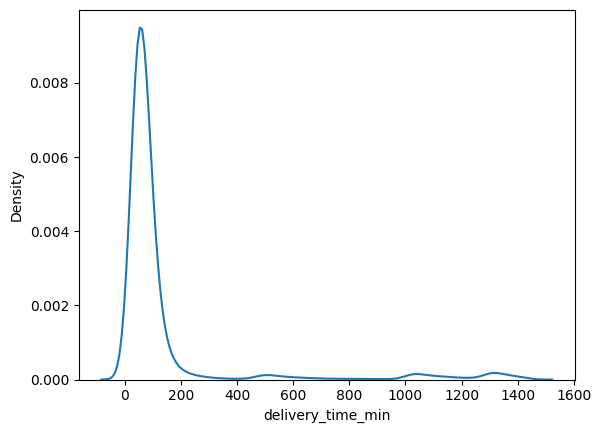

In [636]:
sns.kdeplot(delivery_data,x="delivery_time_min")

### Цена доставки

<Axes: xlabel='sub_total', ylabel='Density'>

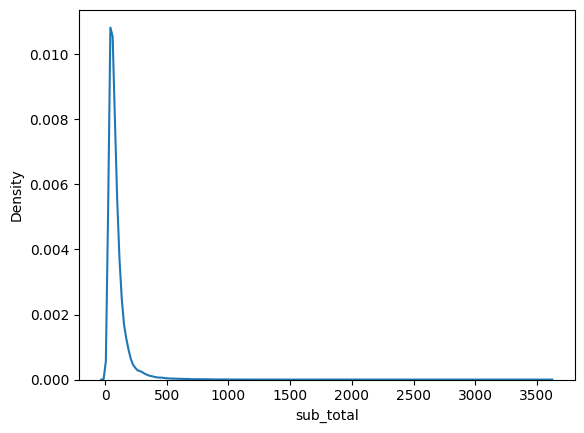

In [637]:
sns.kdeplot(delivery_data,x="sub_total")

#### Аномалия

На графике можно заметить, что цена некотых заказов нулевая

In [638]:
print(f"Количество таких наблюдений: {delivery_data[delivery_data.sub_total==0].customer_id.count()}")

Количество таких наблюдений: 8


In [639]:
delivery_data[delivery_data.sub_total==0].head()

,Date,time_ordered,time_delivered,customer_id,delivery_area,ASAP,sub_total,delivery_fee,service_fee,discount,tip,refund,delivery_time_min
3935,Tuesday,00:00:29,01:06:04,1166937,Hayward,Yes,0.0,7.09,3.62,2.0,0.0,83.59,65.58
12800,Wednesday,00:06:33,00:47:00,1048629,Hayward,Yes,0.0,1.19,3.12,2.0,0.0,0.00,40.45
19653,Monday,23:37:06,00:04:04,1065646,Fremont,Yes,0.0,1.62,4.28,3.0,0.0,0.00,26.97
26851,Saturday,04:19:45,04:49:46,1002074,Union City,Yes,0.0,9.71,4.95,3.0,0.0,114.52,30.02
44056,Friday,03:06:27,04:12:08,1155551,Fremont,Yes,0.0,1.79,4.71,2.0,0.0,0.00,65.68


Возможные причины такого поведения цены включают ошибки транзакций, ошибки со стороны базы данных. Возможно это даже некоторая мошенническая махинация или системная уязвимость, в любом случае наблюдения любопытны и будут устранены

<Axes: xlabel='sub_total', ylabel='Density'>

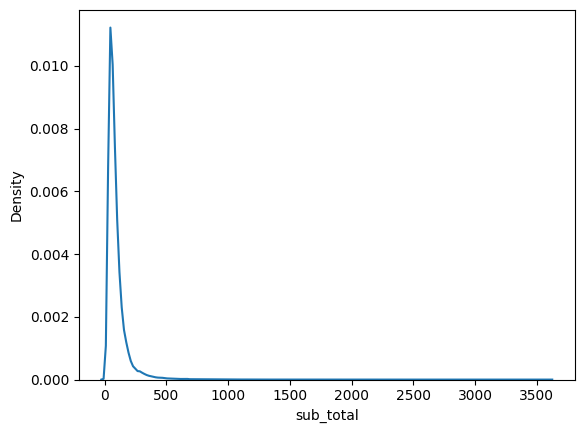

In [640]:
#устранение аномалий
delivery_data = delivery_data[delivery_data.sub_total!=0]
sns.kdeplot(delivery_data,x="sub_total")

### Побочные ценовые компоненты

<Axes: xlabel='delivery_fee', ylabel='Density'>

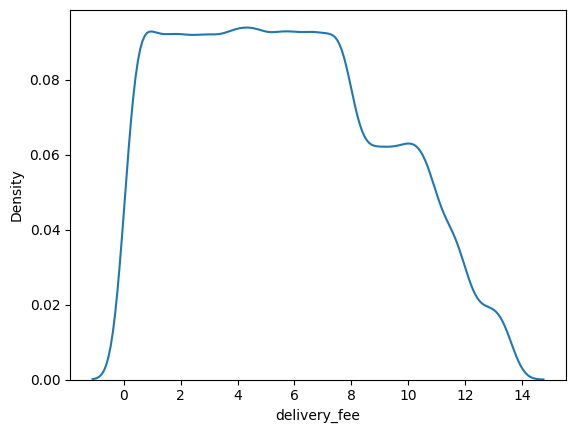

In [641]:
sns.kdeplot(delivery_data,x="delivery_fee")

<Axes: xlabel='service_fee', ylabel='Density'>

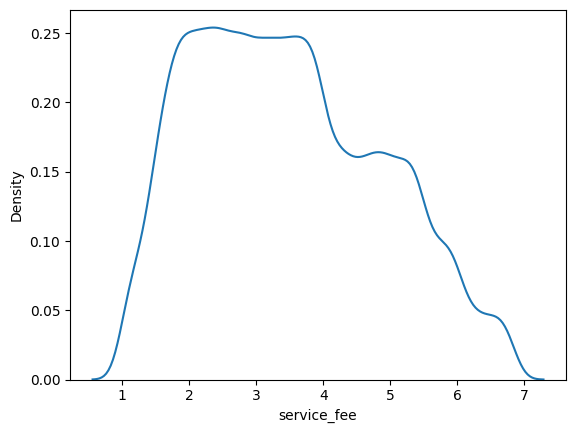

In [642]:
sns.kdeplot(delivery_data,x="service_fee")

<Axes: xlabel='discount', ylabel='Density'>

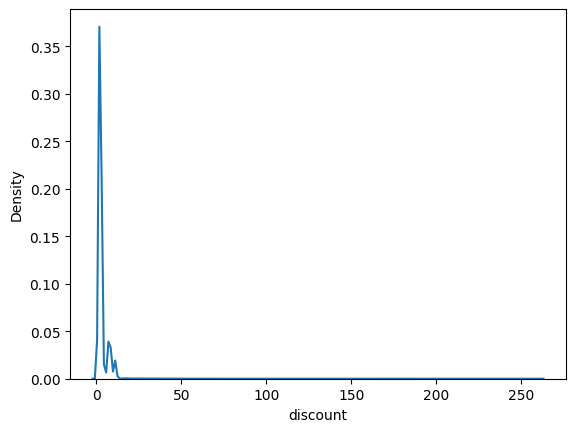

In [643]:
sns.kdeplot(delivery_data,x="discount")

<Axes: xlabel='tip', ylabel='Density'>

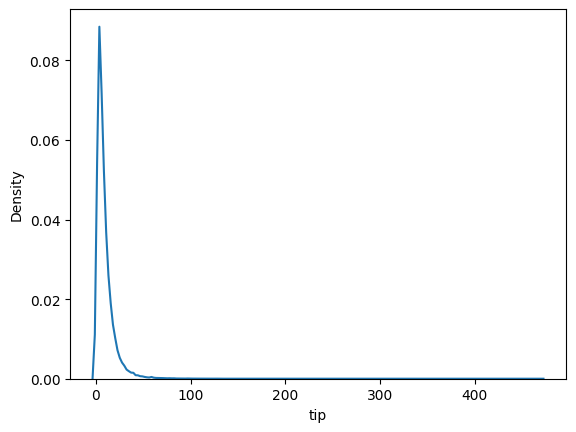

In [644]:
sns.kdeplot(delivery_data,x="tip")

### Дни недели

<Axes: xlabel='Date', ylabel='count'>

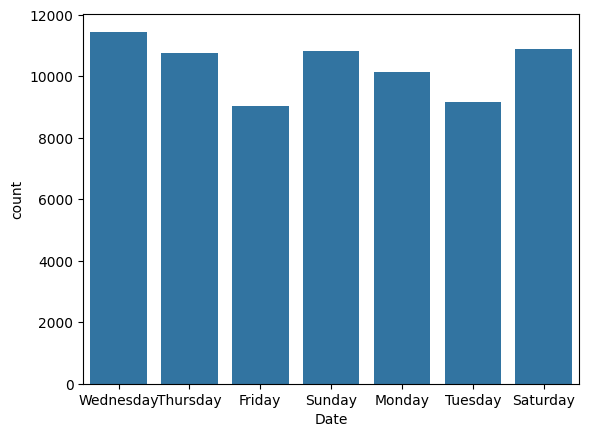

In [645]:
sns.countplot(delivery_data,x="Date")

# Устранение выбросов

## Выбросы веремени доставки

<Axes: xlabel='delivery_time_min', ylabel='Density'>

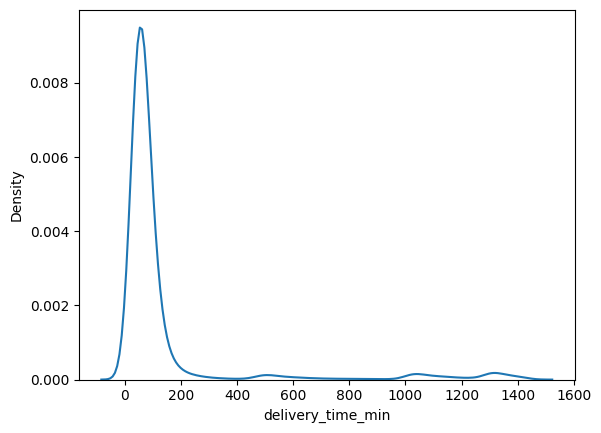

In [646]:
sns.kdeplot(delivery_data,x="delivery_time_min")

<Axes: xlabel='delivery_time_min', ylabel='Density'>

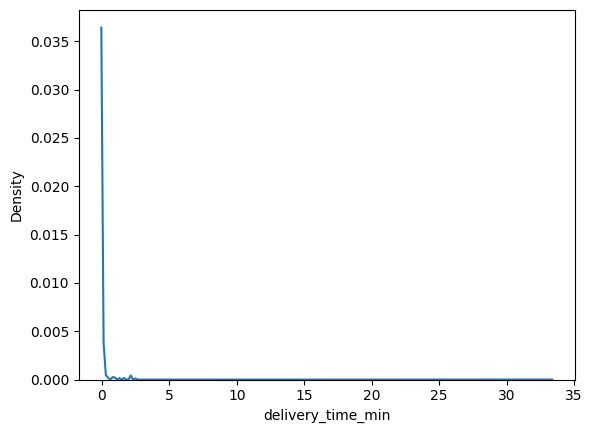

In [647]:
normalized_delivery = 1 / delivery_data.delivery_time_min
sns.kdeplot(normalized_delivery)

In [648]:
print(f"99-й персептиль: {normalized_delivery.quantile(0.99):.6f}")

#сметим все значения к 99-ому пернсептилю
normalized_delivery = normalized_delivery.clip(upper = normalized_delivery.quantile(0.99))

99-й персептиль: 0.041288


<Axes: xlabel='delivery_time_min', ylabel='Density'>

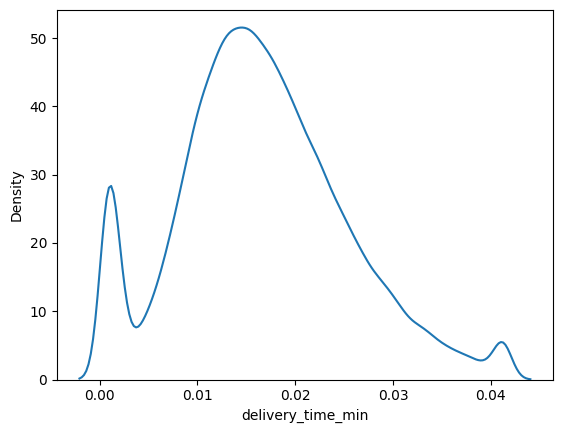

In [649]:
sns.kdeplot(normalized_delivery)

In [650]:
delivery_data["delivery_time_min"] = normalized_delivery

## Выбросы цены

Для цены товара используем обратную конвертацию ("сжимаем большие цены к началу, отдавая приоритет меньшим значениям")

In [651]:
delivery_data["sub_total"] = 1 / delivery_data.sub_total

In [652]:
print(f"99-й персенптиль обратной стоимости товара: {delivery_data.sub_total.quantile(0.99):.2f}")\

threshold = delivery_data.sub_total.quantile(0.99)
# delivery_data = delivery_data[delivery_data.sub_total <=threshold]

delivery_data["sub_total"] = delivery_data["sub_total"].clip(upper=threshold)

99-й персенптиль обратной стоимости товара: 0.05


<Axes: xlabel='sub_total', ylabel='Density'>

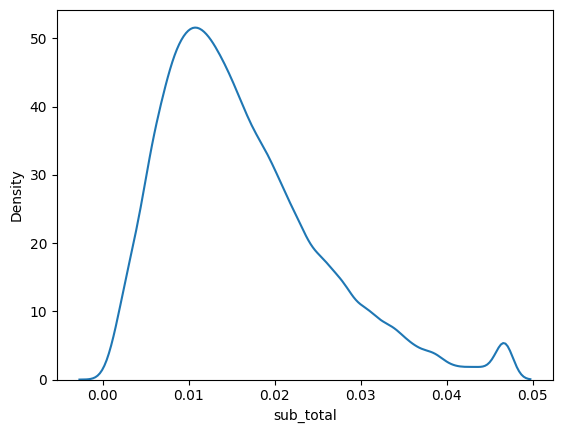

In [653]:
sns.kdeplot(delivery_data,x="sub_total")

## Выбросы скидок и чаевых

In [654]:
#заменим ценовой discount на экивалент % от стоимости 
delivery_data["discount"] = (delivery_data.discount / (1/delivery_data.sub_total)) *100

#тоже самое с tip
delivery_data["tip"] = (delivery_data.tip / (1/delivery_data.sub_total) )*100

<Axes: xlabel='discount', ylabel='Density'>

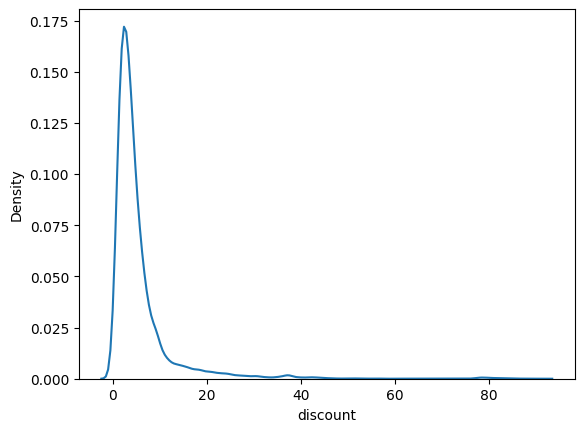

In [655]:
sns.kdeplot(delivery_data,x="discount")

In [656]:
print(f"Максимальная скидка из данных: {delivery_data.discount.max():.2f}")

Максимальная скидка из данных: 91.02


In [657]:
bins = [0,5,10,20,50,92]
labels = ['0-5%', '5-10%', '10-20%', '20-50%', '50-92%']
delivery_data["discount"] = pd.cut(delivery_data.discount,bins=bins,labels=labels)

<Axes: xlabel='discount', ylabel='count'>

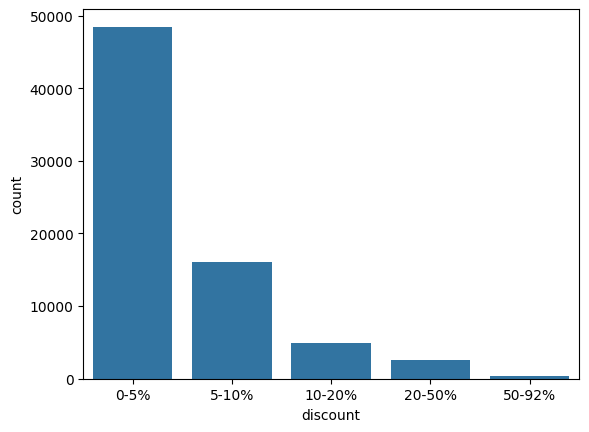

In [658]:
sns.countplot(delivery_data,x="discount")

<Axes: xlabel='tip', ylabel='Density'>

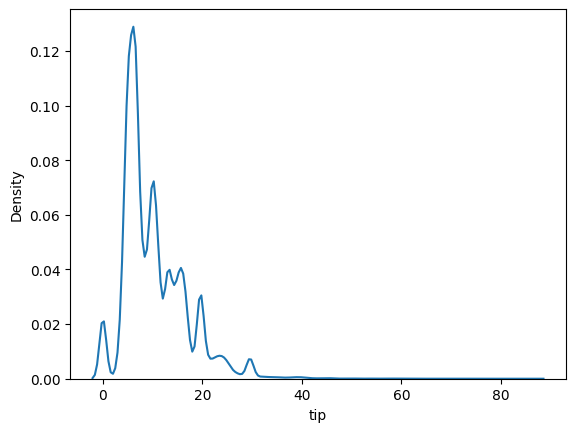

In [659]:
sns.kdeplot(delivery_data,x="tip")

In [660]:
print(f"Максимальные чаевые из данных: {delivery_data.tip.max():.2f}")

Максимальные чаевые из данных: 86.49


In [661]:
bins = [0,5,10,20,50,90]
labels = ['0-5%', '5-10%', '10-20%', '20-50%', '50-90%']
delivery_data["tip"] = pd.cut(delivery_data.tip,bins=bins,labels=labels)

<Axes: xlabel='tip', ylabel='count'>

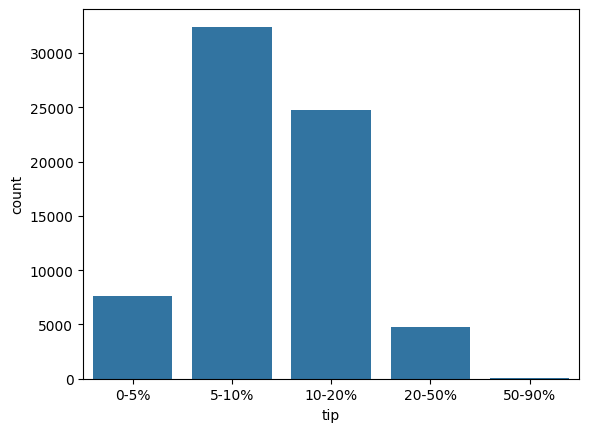

In [662]:
sns.countplot(delivery_data,x="tip")

# Замена классифицируемой переменной на фактор
Исследуется факт возврата, а не вероятное количество возращаемой суммы.

In [663]:
delivery_data["refund"] = delivery_data.refund >0

# updated EDA Анализ взаимодействий переменных

## Скидки

<Axes: xlabel='discount', ylabel='count'>

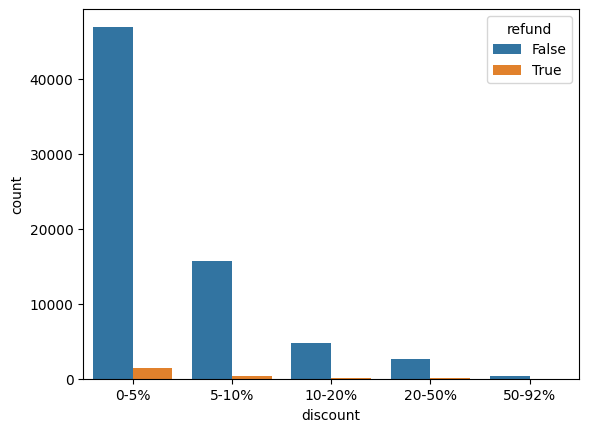

In [664]:
sns.countplot(delivery_data,x="discount",hue="refund")

### Рассмотрим поближе экстремальные случаи

<Axes: xlabel='discount', ylabel='count'>

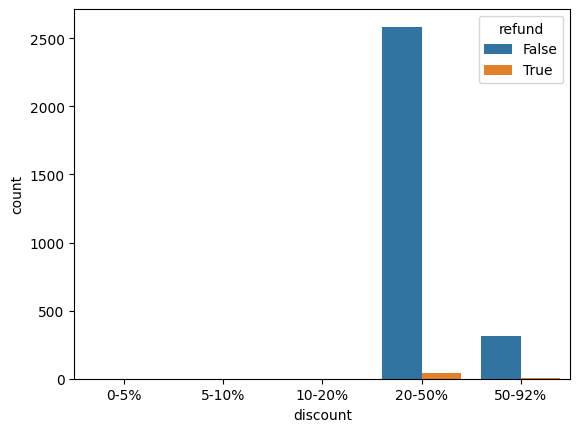

In [665]:
sns.countplot(delivery_data[(delivery_data.discount=="20-50%") | (delivery_data.discount=="50-92%")],x="discount",hue="refund")

Анализ показывает, что возвраты происходят чаще, если скидка маленькая и реже, если скидка большая

<Axes: xlabel='discount', ylabel='sub_total'>

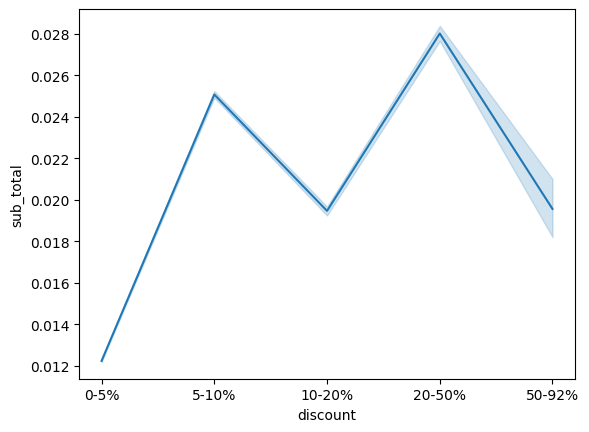

In [666]:
sns.lineplot(delivery_data,x= "discount",y="sub_total")

<Axes: xlabel='discount', ylabel='delivery_time_min'>

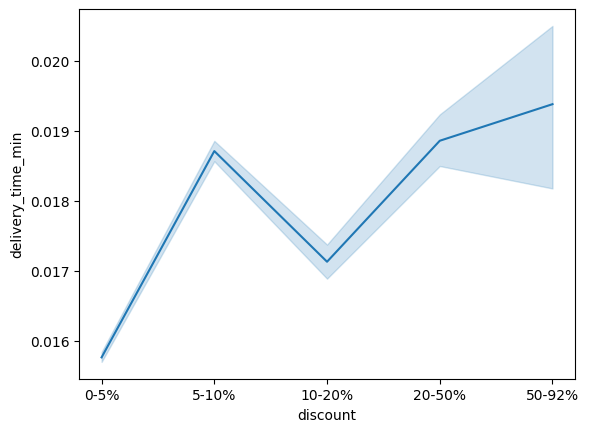

In [667]:
sns.lineplot(delivery_data,y="delivery_time_min",x="discount")

## Сторонние фаторы цены

<Axes: xlabel='delivery_fee', ylabel='sub_total'>

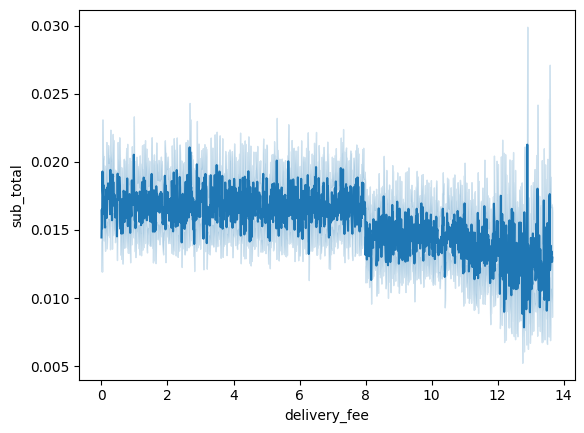

In [668]:
sns.lineplot(delivery_data,x="delivery_fee", y="sub_total")

<Axes: xlabel='service_fee', ylabel='sub_total'>

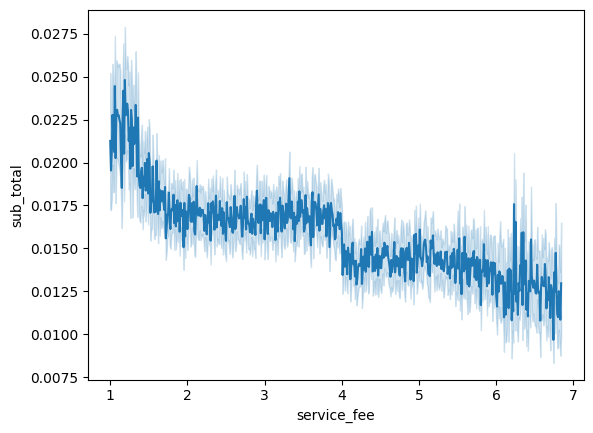

In [669]:
sns.lineplot(delivery_data,x="service_fee",y="sub_total")

### Корреляция с возвратом

<Axes: xlabel='service_fee'>

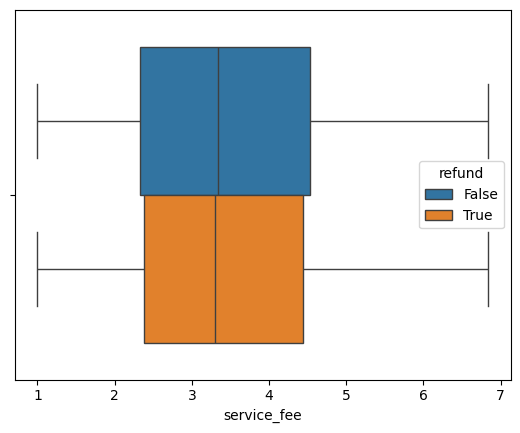

In [670]:
sns.boxplot(delivery_data, x="service_fee", hue="refund")

<Axes: xlabel='refund', ylabel='service_fee'>

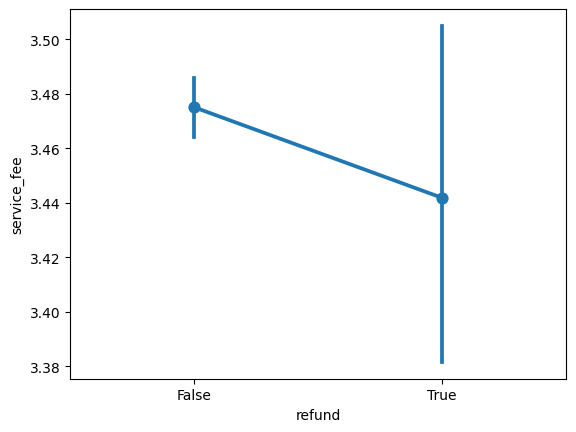

In [671]:
sns.pointplot(delivery_data, y="service_fee", x="refund")

<Axes: xlabel='delivery_fee'>

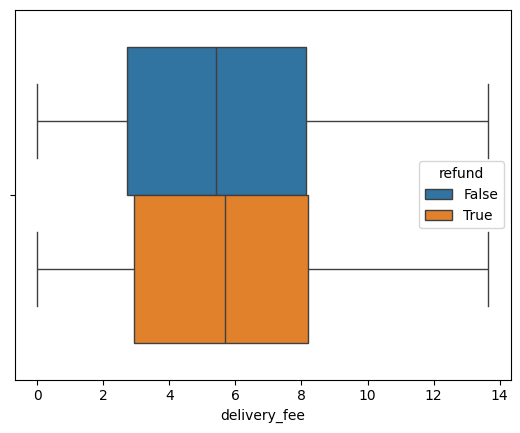

In [672]:
sns.boxplot(delivery_data, x="delivery_fee", hue="refund")

<Axes: xlabel='refund', ylabel='delivery_fee'>

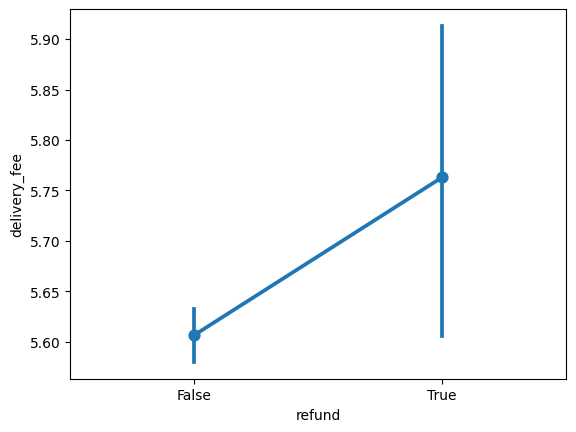

In [673]:
sns.pointplot(delivery_data, y="delivery_fee", x="refund")

Даже если различия статистически значимы, смещение медиан в обоих случаях настоллько незначительное, что практически не дает нам данных.
Кроме того, переменная стоимости сервиса коррелирует со стоимостью.
Было решено объединить эти параметры для улучшения модели

## Время доставки

<Axes: xlabel='delivery_time_min'>

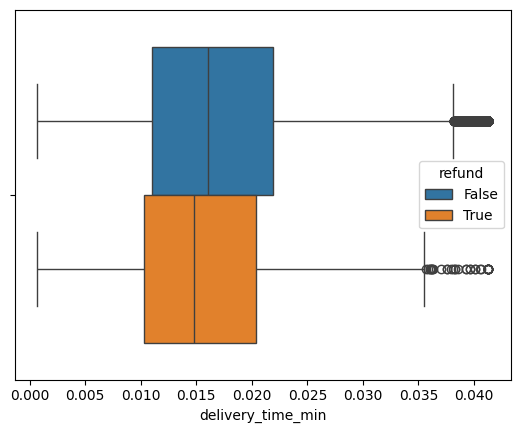

In [674]:
sns.boxplot(delivery_data,x = "delivery_time_min", hue="refund")

<Axes: xlabel='refund', ylabel='delivery_time_min'>

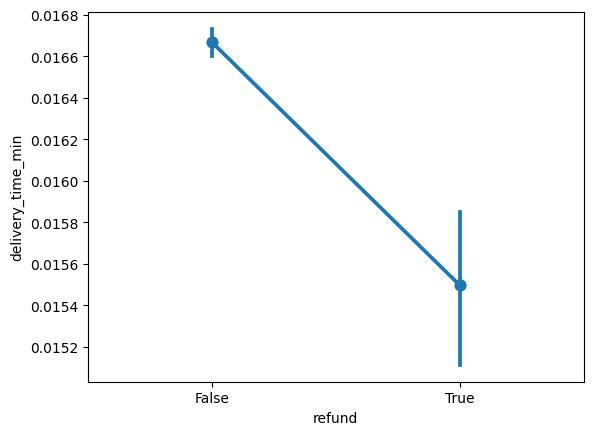

In [675]:
sns.pointplot(delivery_data,x="refund",y="delivery_time_min")

<Axes: xlabel='ASAP', ylabel='delivery_time_min'>

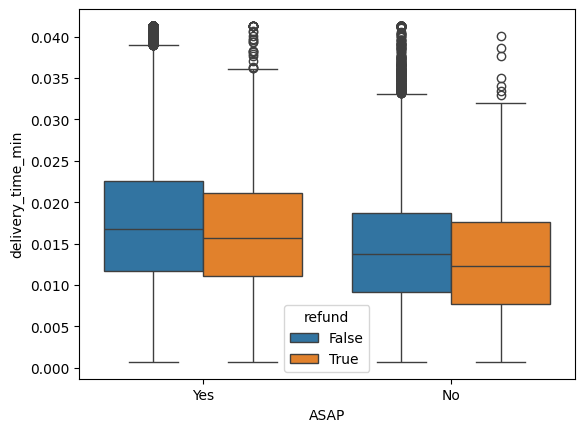

In [676]:
sns.boxplot(delivery_data, x="ASAP",y="delivery_time_min", hue="refund")

<Axes: xlabel='refund', ylabel='delivery_time_min'>

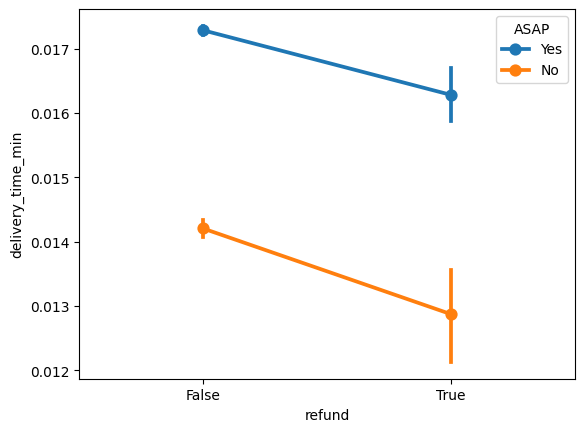

In [677]:
sns.pointplot(delivery_data,x="refund",y="delivery_time_min", hue = "ASAP")

## Чаевые

<Axes: xlabel='tip', ylabel='count'>

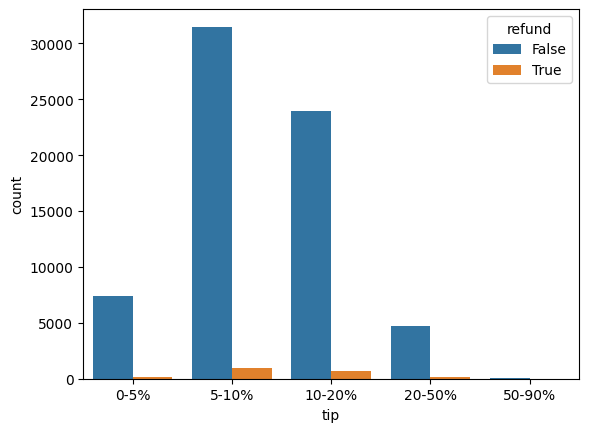

In [678]:
sns.countplot(delivery_data,x="tip",hue="refund")

## Дни недели

<Axes: xlabel='Date', ylabel='count'>

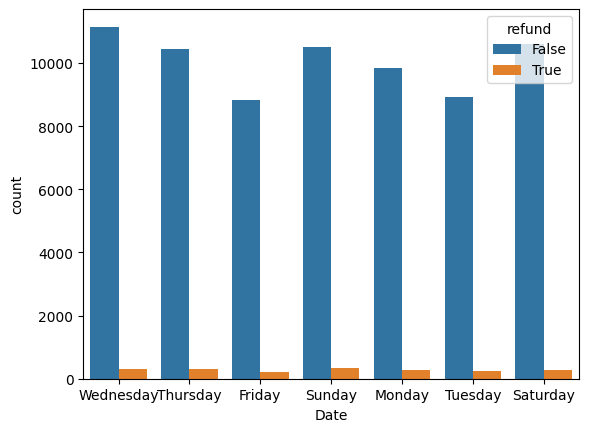

In [679]:
sns.countplot(delivery_data,x="Date",hue="refund")

# Feature engineering

## Объединяем цены

In [680]:
#объединяем цены
delivery_data["sub_total"] = (1 / 
                              ((1/ delivery_data.sub_total) + delivery_data.delivery_fee + delivery_data.service_fee))

#старые переменные уже не нужны
delivery_data = delivery_data.drop(["delivery_fee","service_fee"],axis=1)

<Axes: xlabel='sub_total', ylabel='Density'>

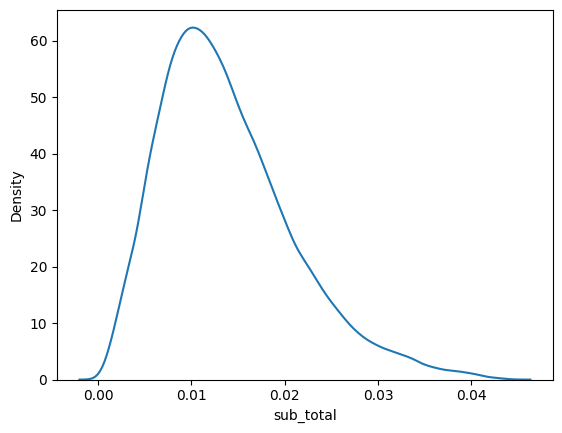

In [681]:
sns.kdeplot(delivery_data, x="sub_total")

## Распределение по времени заказа
Распределим время как утро, день, вечер, ночь

In [682]:
# ночь (00:00:00 - 04:59:59)
# утро (05:00:00 - 09:59:59)
# день (10:00:00 - 16:59:59)
# вечер (17:00:00 - 21:59:59)
# ночь (22:00:00 - 23:59:59)

labels = ["ночь", "утро", "день", "вечер", "ночь"]

# Преобразуем время в секунды
time_delivered_seconds =(
    time_delivered.dt.hour * 3600 +
    time_delivered.dt.minute *60 +
    time_delivered.dt.second
)

time_ordered_seconds =(
    time_ordered.dt.hour * 3600 +
    time_ordered.dt.minute *60 +
    time_ordered.dt.second
)

delivery_data["time_delivered"] = pd.cut(time_delivered_seconds,
        bins =[0,5*3600, 10*3600, 17*3600, 22*3600, 24*3600], 
        labels=labels, ordered = False)

delivery_data["time_ordered"] = pd.cut(time_ordered_seconds,
        bins =[0,5*3600, 10*3600, 17*3600, 22*3600, 24*3600], 
        labels=labels, ordered = False)

In [683]:
delivery_data.head()

,Date,time_ordered,time_delivered,customer_id,delivery_area,ASAP,sub_total,discount,tip,refund,delivery_time_min
0,Wednesday,ночь,ночь,1143515,Fremont,Yes,0.038986,5-10%,5-10%,False,0.023186
1,Wednesday,день,вечер,1136820,Hayward,Yes,0.009252,0-5%,10-20%,False,0.005616
2,Wednesday,вечер,вечер,1081871,Hayward,Yes,0.036900,20-50%,10-20%,False,0.035051
3,Wednesday,ночь,ночь,1128255,Union City,Yes,0.028201,5-10%,20-50%,False,0.027778
4,Wednesday,ночь,ночь,1051183,Hayward,Yes,0.013390,0-5%,10-20%,False,0.019755


# Final EDA

## Зависимость дня недели и возврата

<Axes: ylabel='refund'>

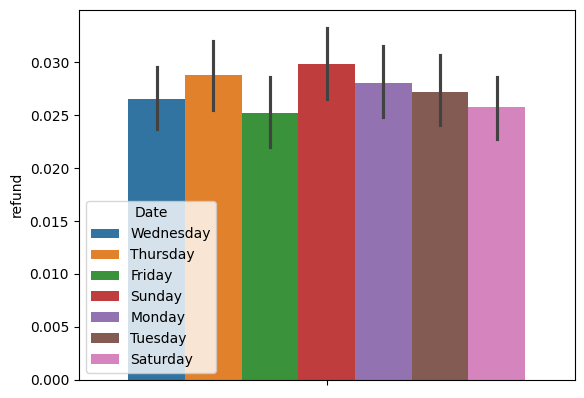

In [684]:
sns.barplot(delivery_data,hue="Date", y="refund")

In [685]:
date_refund_table = pd.crosstab(delivery_data.Date, delivery_data.refund)

In [686]:
print(f"Уровень p-value Хи-квадрат теста: {chi2_contingency(date_refund_table).pvalue:.2f}")

Уровень p-value Хи-квадрат теста: 0.37


## Промежуток времени оформления заказа и возврат

### Время заказа позиции

<Axes: xlabel='time_ordered', ylabel='count'>

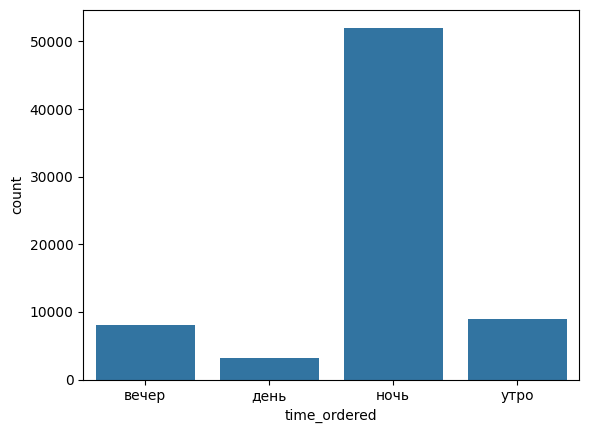

In [687]:
sns.countplot(delivery_data,x="time_ordered")

<Axes: ylabel='refund'>

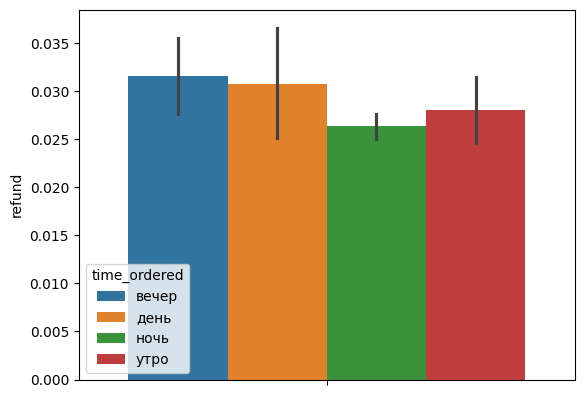

In [688]:
sns.barplot(delivery_data,y="refund", hue="time_ordered")

In [689]:
pd.crosstab(delivery_data.time_ordered,delivery_data.refund)

refund,False,True
time_ordered,,
вечер,7868,257
день,3121,99
ночь,50664,1374
утро,8669,250


In [690]:
print(f"Уровень p-value Хи-квадрат теста: {chi2_contingency(pd.crosstab(delivery_data.time_ordered,delivery_data.refund)).pvalue:.2f}")

Уровень p-value Хи-квадрат теста: 0.03


### Время приезда заказа клиенту

<Axes: xlabel='time_delivered', ylabel='count'>

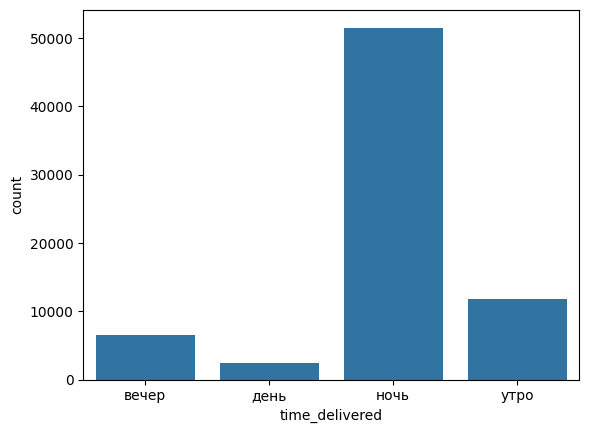

In [691]:
sns.countplot(delivery_data,x="time_delivered")

<Axes: ylabel='refund'>

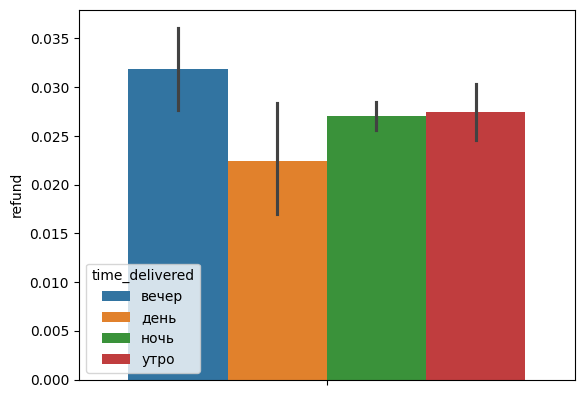

In [692]:
sns.barplot(delivery_data,y="refund",hue="time_delivered")

In [693]:
pd.crosstab(delivery_data.time_delivered, delivery_data.refund)

refund,False,True
time_delivered,,
вечер,6325,208
день,2305,53
ночь,50162,1394
утро,11534,325


In [694]:
print(f"Уровень p-value Хи-квадрат теста: {chi2_contingency(pd.crosstab(delivery_data.time_delivered, delivery_data.refund)).pvalue:.2f}")

Уровень p-value Хи-квадрат теста: 0.06


## Место проведения доставок

<Axes: ylabel='refund'>

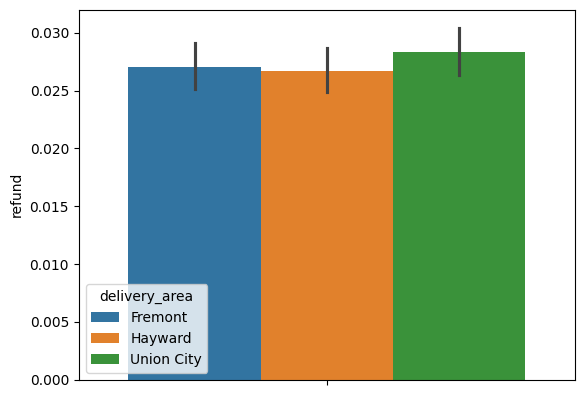

In [695]:
sns.barplot(delivery_data,y="refund",hue="delivery_area")

In [696]:
pd.crosstab(delivery_data.delivery_area, delivery_data.refund)

refund,False,True
delivery_area,,
Fremont,23571,656
Hayward,23439,643
Union City,23316,681


In [697]:
print(f"Уровень p-value Хи-квадрат теста: {chi2_contingency(pd.crosstab(delivery_data.delivery_area, delivery_data.refund)).pvalue:.2f}")

Уровень p-value Хи-квадрат теста: 0.50


## As Soon As Possible показатель

<Axes: xlabel='ASAP', ylabel='refund'>

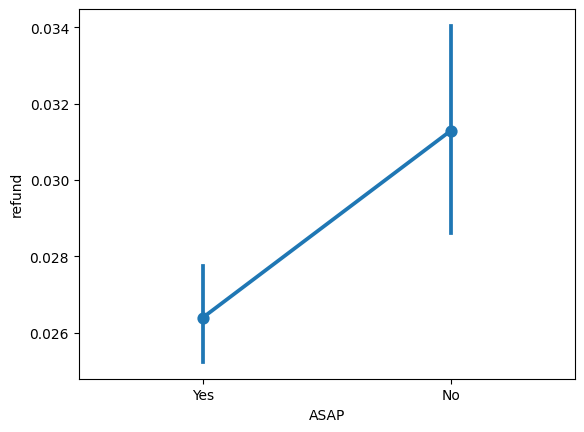

In [698]:
sns.pointplot(delivery_data,y="refund",x="ASAP")

In [699]:
cross_tab = pd.crosstab(delivery_data.ASAP,delivery_data.refund)
cross_tab

refund,False,True
ASAP,,
No,14115,456
Yes,56211,1524


In [700]:
print(f"Уровень p-value Хи-квадрат теста: {chi2_contingency(cross_tab).pvalue:.2f}")

Уровень p-value Хи-квадрат теста: 0.00


сила связи по формуле Cramers V не подходит из-за дисбаланса классов. Посмотрим средние отношения и доверительные интервалы по ним

In [701]:
proportions = delivery_data.groupby("ASAP")["refund"].mean()
print(f"Средний процент возврата в группе ASAP '{proportions.index[0]}': {proportions.iloc[0]:.3f}")

print(f"Средний процент возврата в группе ASAP '{proportions.index[1]}': {proportions.iloc[1]:.3f}")

print(f"Относительный риск между первой и 2-й группами: '{proportions.index[0]}': {proportions.iloc[0] / proportions.iloc[1]:.3f} ({((proportions.iloc[0] / proportions.iloc[1])-1)*100:.3f}%)")

Средний процент возврата в группе ASAP 'No': 0.031
Средний процент возврата в группе ASAP 'Yes': 0.026
Относительный риск между первой и 2-й группами: 'No': 1.186 (18.558%)


Практическая значимость объясняется тем, что при факторе ASAP "No" вероятность возврата на 13% болше, чем с ASAP "Yes".
Вероятно причиной является взаимодействие факторов времени и требует дополнительного анализа

#### Взаимодействие с временем доставки

<Axes: xlabel='ASAP', ylabel='delivery_time_min'>

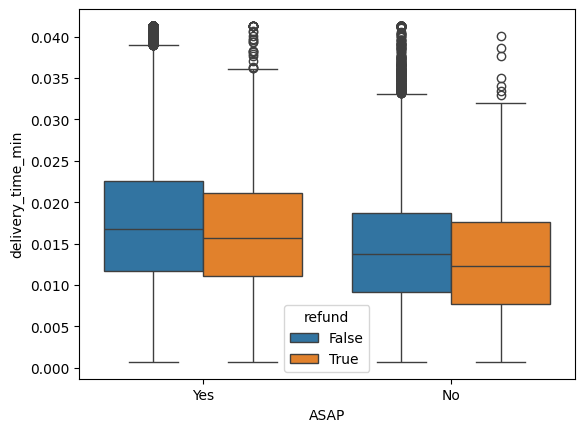

In [702]:
sns.boxplot(delivery_data, y="delivery_time_min",x="ASAP",hue="refund")

In [ ]:
time_table = 1 / delivery_data.groupby(["refund","ASAP"]).delivery_time_min.mean()
print(f"Разница средних в группе {time_table.iloc[2] - time_table.iloc[0]:.2f}")
time_table

-7.29


refund  ASAP
False   No      70.397742
        Yes     57.849118
True    No      77.687968
        Yes     61.420100
Name: delivery_time_min, dtype: float64

Хоть разница и статистически значима, практическая ценность взаимодействия фактора ASAP и время доставки сомнительно

## Цена товара

<Axes: ylabel='sub_total'>

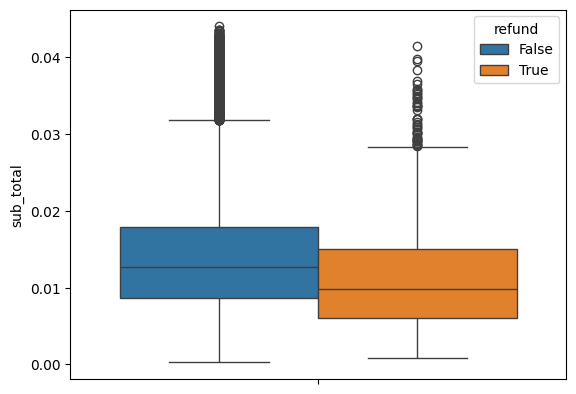

In [704]:
sns.boxplot(delivery_data, y="sub_total", hue="refund")

<Axes: xlabel='refund', ylabel='sub_total'>

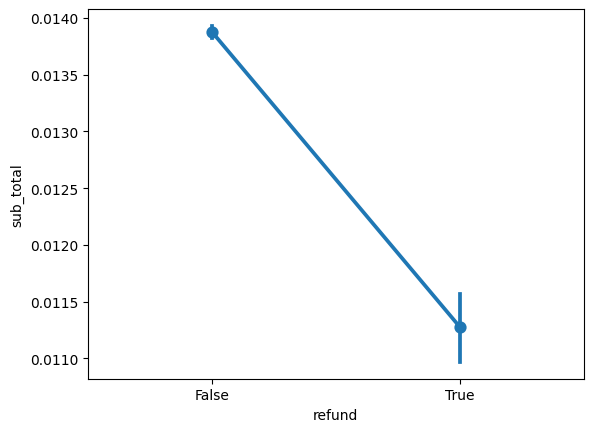

In [705]:
sns.pointplot(delivery_data, y="sub_total",x="refund")

In [706]:
print(f"p-value теста манауитни {mannwhitneyu(delivery_data.sub_total,delivery_data.refund).pvalue:.2f}")

p-value теста манауитни 0.00


In [707]:
print(f"Средня цена товара  датасете: {1 / delivery_data.sub_total.mean():.2f}$")

Средня цена товара  датасете: 72.42$


In [708]:
1 / delivery_data.groupby("refund")["sub_total"].describe().drop(["count","min","max","std"],axis=1)

,mean,25%,50%,75%
refund,,,,
False,72.045998,115.817500,78.750000,55.82
True,88.677047,165.079984,101.349952,66.65


Хоть и разницы между ценами оказались статистически значимы практической разница в данных очень мало (разница в )

## Скидка

<Axes: ylabel='refund'>

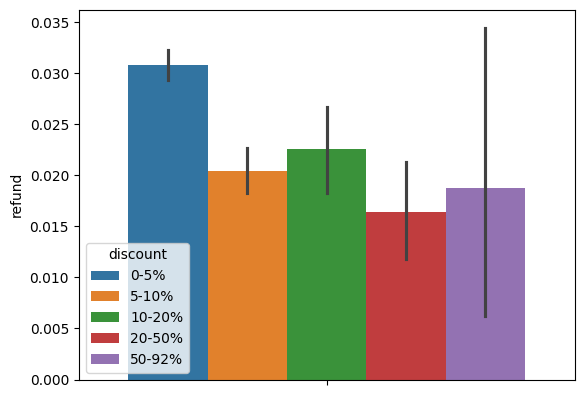

In [709]:
sns.barplot(delivery_data,y="refund",hue="discount")

In [710]:
cross_tab = pd.crosstab(delivery_data.discount,delivery_data.refund)
cross_tab

refund,False,True
discount,,
0-5%,46974,1493
5-10%,15697,328
10-20%,4756,110
20-50%,2585,43
50-92%,313,6


In [711]:
print(f"p-value Хи квадрат для переменных: {chi2_contingency(cross_tab).pvalue:.2f}")

p-value Хи квадрат для переменных: 0.00


## Чаевые

<Axes: ylabel='refund'>

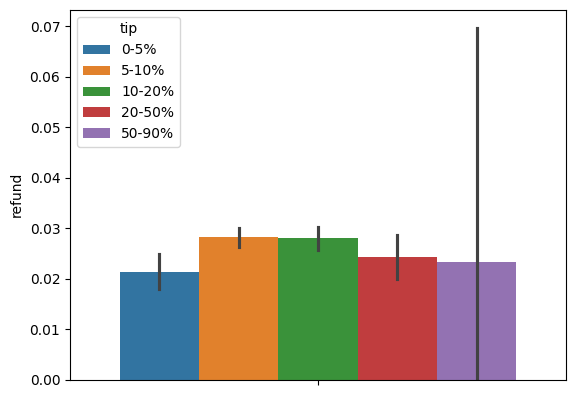

In [ ]:
sns.barplot(delivery_data,y="refund",hue="tip")

<Axes: xlabel='tip', ylabel='refund'>

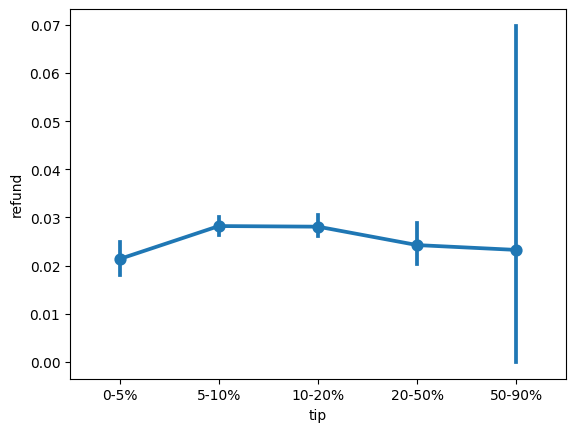

In [ ]:
sns.pointplot(delivery_data, y="refund", x="tip")

In [ ]:
cross_tab = pd.crosstab(delivery_data.tip, delivery_data.refund)
cross_tab

refund,False,True
tip,,
0-5%,6778,148
5-10%,28314,822
10-20%,21595,624
20-50%,4183,104
50-90%,42,1


In [ ]:
print(f"p-value Хи-квадрат теста: {chi2_contingency(cross_tab).pvalue:.2f}")

p-value Хи-квадрат теста: 0.02


In [ ]:
print(f"Уровень силы связи Хи-квадрат теста: {cramer_V(cross_tab):.2f}")

Уровень силы связи Хи-квадрат теста: 0.01


## Время доставки

<Axes: ylabel='delivery_time_min'>

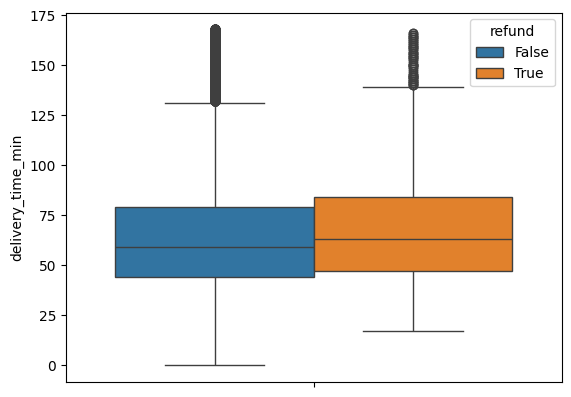

In [ ]:
sns.boxplot(delivery_data,y="delivery_time_min",hue="refund")

<Axes: xlabel='refund', ylabel='delivery_time_min'>

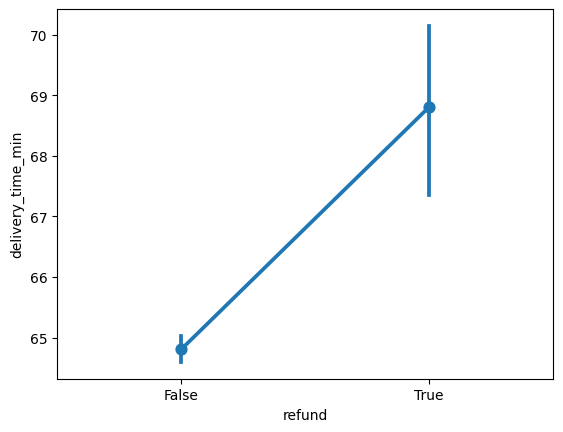

In [ ]:
sns.pointplot(delivery_data,x="refund",y="delivery_time_min")

In [ ]:
print(f"P-value теста Манауитни: {mannwhitneyu(delivery_data.delivery_time_min,delivery_data.refund).pvalue:.2f}")

P-value теста Манауитни: 0.00


# Создание модели

In [ ]:
from sklearn.linear_model  import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import RocCurveDisplay

In [ ]:
delivery_data.set_index("customer_id")
dataset = pd.get_dummies(delivery_data)

X = dataset.drop(["refund"],axis=1)
Y = dataset["refund"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25)

## Логистическая регрессия

### Без предварительной подготовки моделиэ
Изучим поведение модели без предварительного изменения гиперпараметров

In [ ]:
clf = LogisticRegression(random_state=42, max_iter=1000)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# parameters = [
#     #Параметры для l1 регуляризации
#     {"penalty":["l1"],
#     "fit_intercept":[True,False],
#     "class_weight":["balanced",None],
#     "solver":["liblinear","saga"]},
    
#     #Параметры для l2 регуляризации
#     {"penalty":["l2"],
#     "fit_intercept":[True,False],
#     "class_weight":["balanced",None]
#     ]

# search = GridSearchCV(clf,param_grid=parameters, cv = 5, scoring="f1")
# search.fit(X_train, y_train)

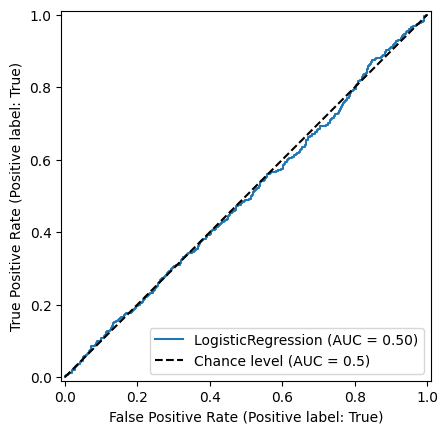

In [ ]:
RocCurveDisplay.from_estimator(clf,X_test,y_test, plot_chance_level=True)

#### Итеративное снижение параметров

In [ ]:
delivery_data.head()

,Date,time_ordered,time_delivered,customer_id,delivery_area,ASAP,sub_total,discount,tip,refund,delivery_time_min
0,Wednesday,ночь,ночь,1143515,Fremont,Yes,0.038986,5-10%,5-10%,False,43
2,Wednesday,вечер,вечер,1081871,Hayward,Yes,0.036900,20-50%,10-20%,False,29
3,Wednesday,ночь,ночь,1128255,Union City,Yes,0.028201,5-10%,20-50%,False,36
4,Wednesday,ночь,ночь,1051183,Hayward,Yes,0.013390,0-5%,10-20%,False,51
5,Wednesday,ночь,ночь,1129838,Hayward,Yes,0.031348,20-50%,5-10%,False,46


In [ ]:
dataset = pd.get_dummies(delivery_data)
X = dataset.drop(["refund"],axis=1)
Y = dataset["refund"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25)

##

## Дерево решений

In [ ]:
# clf = DecisionTreeClassifier()
# parameters = {"max_depth":range(1,10),"class_weight":["balanced","None"]}
# search = GridSearchCV(clf,param_grid=parameters)

In [ ]:
# search.fit(X_train, y_train)

In [ ]:
# plot_tree(search.best_estimator_,filled=True, feature_names=X_test.columns)

In [ ]:
# RocCurveDisplay.from_estimator(search.best_estimator_,X_test,y_test, plot_chance_level=True)